<a href="https://colab.research.google.com/github/AllisonOge/predictive_modeling/blob/version2.0/predictive_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

import warnings

warnings.filterwarnings("ignore")

In [4]:
%matplotlib inline
# increase the figure size
sns.set(rc={'figure.figsize': (15, 5)})
sns.set_style("whitegrid")

In [5]:
sensor_df = pd.read_csv("https://raw.githubusercontent.com/AllisonOge/predictive_modeling/main/data/sensor_ml.csv", index_col="id")
# sensor_df = pd.read_csv("sensor_ml.csv", index_col="id")

In [6]:
sensor_copy_df = sensor_df
sensor_copy_df = sensor_copy_df.drop_duplicates(subset="created_at")
sensor_copy_df = sensor_copy_df.set_index("created_at")

In [7]:
sensor_copy_df

,chan_1,chan_2,chan_3,chan_4
created_at,,,,
2022-11-15 16:14:18.829480,1,0,0,0
2022-11-15 16:14:18.914676,1,0,0,0
2022-11-15 16:14:18.983745,1,0,0,0
2022-11-15 16:14:19.059611,1,0,0,0
2022-11-15 16:14:19.134008,1,0,0,0
...,...,...,...,...
2022-11-15 16:44:18.563776,1,1,1,1
2022-11-15 16:44:18.693114,1,1,1,1
2022-11-15 16:44:18.755782,1,1,1,1


In [8]:
idle_times_df = pd.read_csv("./data/idletimes.csv", index_col="created_at")
idle_times_df

,chan_1,chan_2,chan_3,chan_4
created_at,,,,
2022-11-15 16:14:18.829480,0,16,16,16
2022-11-15 16:14:18.914676,0,15,15,15
2022-11-15 16:14:18.983745,0,14,14,14
2022-11-15 16:14:19.059611,0,13,13,13
2022-11-15 16:14:19.134008,0,12,12,12
...,...,...,...,...
2022-11-15 16:44:18.563776,0,0,0,0
2022-11-15 16:44:18.693114,0,0,0,0
2022-11-15 16:44:18.755782,0,0,0,0


In [9]:
def df_to_X_y(df1, df2, window_size=10):
  X = []
  y = []
  for i in range(df1.shape[0]-window_size):
    X.append([r for r in df1.to_numpy()[i:i+window_size]])
    y.append(df2.to_numpy()[i+window_size])
  return np.array(X), np.array(y)

In [10]:
scaler = MinMaxScaler()
idle_times_transformed_df = pd.DataFrame(scaler.fit_transform((idle_times_df)), index=idle_times_df.index, columns=idle_times_df.columns)

In [11]:
X, y = df_to_X_y(sensor_copy_df, idle_times_transformed_df, window_size=25)
X.shape, y.shape

((23545, 25, 4), (23545, 4))

In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5)
X_train.shape, X_test.shape, X_val.shape

((18836, 25, 4), (2354, 25, 4), (2355, 25, 4))

## Build the model 🧠

In [15]:
def build_model(input_shape):
  return tf.keras.models.Sequential([
      tf.keras.layers.Input(input_shape),
      tf.keras.layers.LSTM(45, return_sequences=True),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.LSTM(45, return_sequences=True),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.LSTM(45),
      tf.keras.layers.Dense(45, activation="relu"),
      tf.keras.layers.Dense(4, activation="relu")
  ])

In [16]:
model = build_model((X.shape[1], X.shape[2]))
model.summary()

2022-12-30 16:25:06.082712: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-30 16:25:06.082748: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-30 16:25:06.082772: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (codespaces-49872f): /proc/driver/nvidia/version does not exist
2022-12-30 16:25:06.083038: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25, 45)            9000      
                                                                 
 dropout (Dropout)           (None, 25, 45)            0         
                                                                 
 lstm_1 (LSTM)               (None, 25, 45)            16380     
                                                                 
 dropout_1 (Dropout)         (None, 25, 45)            0         
                                                                 
 lstm_2 (LSTM)               (None, 45)                16380     
                                                                 
 dense (Dense)               (None, 45)                2070      
                                                                 
 dense_1 (Dense)             (None, 4)                 1

In [17]:
model.compile(loss="mse", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

In [18]:
callback = tf.keras.callbacks.ModelCheckpoint("./models/ckpt", verbose=1, save_best_only=True, monitor="val_loss", mode="min")

In [19]:
history = model.fit(X_train, y_train, batch_size=16, epochs=40, callbacks=[callback], validation_data=(X_val, y_val))

Epoch 1/40
1178/1178 [==============================] - ETA: 0s - loss: 0.0128 - accuracy: 0.6340
Epoch 1: val_loss improved from inf to 0.01180, saving model to ./models/ckpt


INFO:tensorflow:Assets written to: ./models/ckpt/assets


INFO:tensorflow:Assets written to: ./models/ckpt/assets


1178/1178 [==============================] - 47s 36ms/step - loss: 0.0128 - accuracy: 0.6340 - val_loss: 0.0118 - val_accuracy: 0.6637
Epoch 2/40
1177/1178 [============================>.] - ETA: 0s - loss: 0.0117 - accuracy: 0.6867
Epoch 2: val_loss improved from 0.01180 to 0.01103, saving model to ./models/ckpt


INFO:tensorflow:Assets written to: ./models/ckpt/assets


INFO:tensorflow:Assets written to: ./models/ckpt/assets


1178/1178 [==============================] - 43s 36ms/step - loss: 0.0117 - accuracy: 0.6866 - val_loss: 0.0110 - val_accuracy: 0.7040
Epoch 3/40
1177/1178 [============================>.] - ETA: 0s - loss: 0.0112 - accuracy: 0.7060
Epoch 3: val_loss improved from 0.01103 to 0.01083, saving model to ./models/ckpt


INFO:tensorflow:Assets written to: ./models/ckpt/assets


INFO:tensorflow:Assets written to: ./models/ckpt/assets


1178/1178 [==============================] - 41s 35ms/step - loss: 0.0112 - accuracy: 0.7060 - val_loss: 0.0108 - val_accuracy: 0.7270
Epoch 4/40
1176/1178 [============================>.] - ETA: 0s - loss: 0.0109 - accuracy: 0.7213
Epoch 4: val_loss improved from 0.01083 to 0.01071, saving model to ./models/ckpt


INFO:tensorflow:Assets written to: ./models/ckpt/assets


INFO:tensorflow:Assets written to: ./models/ckpt/assets


1178/1178 [==============================] - 40s 34ms/step - loss: 0.0109 - accuracy: 0.7214 - val_loss: 0.0107 - val_accuracy: 0.7223
Epoch 5/40
1176/1178 [============================>.] - ETA: 0s - loss: 0.0107 - accuracy: 0.7348
Epoch 5: val_loss improved from 0.01071 to 0.01037, saving model to ./models/ckpt


INFO:tensorflow:Assets written to: ./models/ckpt/assets


INFO:tensorflow:Assets written to: ./models/ckpt/assets


1178/1178 [==============================] - 40s 34ms/step - loss: 0.0107 - accuracy: 0.7349 - val_loss: 0.0104 - val_accuracy: 0.7966
Epoch 6/40
1177/1178 [============================>.] - ETA: 0s - loss: 0.0105 - accuracy: 0.7559
Epoch 6: val_loss did not improve from 0.01037
1178/1178 [==============================] - 30s 26ms/step - loss: 0.0105 - accuracy: 0.7558 - val_loss: 0.0104 - val_accuracy: 0.7728
Epoch 7/40
1177/1178 [============================>.] - ETA: 0s - loss: 0.0103 - accuracy: 0.7592
Epoch 7: val_loss improved from 0.01037 to 0.01019, saving model to ./models/ckpt


INFO:tensorflow:Assets written to: ./models/ckpt/assets


INFO:tensorflow:Assets written to: ./models/ckpt/assets


1178/1178 [==============================] - 41s 34ms/step - loss: 0.0103 - accuracy: 0.7592 - val_loss: 0.0102 - val_accuracy: 0.7898
Epoch 8/40
1177/1178 [============================>.] - ETA: 0s - loss: 0.0102 - accuracy: 0.7622
Epoch 8: val_loss improved from 0.01019 to 0.01003, saving model to ./models/ckpt


INFO:tensorflow:Assets written to: ./models/ckpt/assets


INFO:tensorflow:Assets written to: ./models/ckpt/assets


1178/1178 [==============================] - 40s 34ms/step - loss: 0.0102 - accuracy: 0.7622 - val_loss: 0.0100 - val_accuracy: 0.8021
Epoch 9/40
1177/1178 [============================>.] - ETA: 0s - loss: 0.0101 - accuracy: 0.7737
Epoch 9: val_loss improved from 0.01003 to 0.00987, saving model to ./models/ckpt


INFO:tensorflow:Assets written to: ./models/ckpt/assets


INFO:tensorflow:Assets written to: ./models/ckpt/assets


1178/1178 [==============================] - 40s 34ms/step - loss: 0.0101 - accuracy: 0.7737 - val_loss: 0.0099 - val_accuracy: 0.7983
Epoch 10/40
1177/1178 [============================>.] - ETA: 0s - loss: 0.0099 - accuracy: 0.7766
Epoch 10: val_loss improved from 0.00987 to 0.00969, saving model to ./models/ckpt


INFO:tensorflow:Assets written to: ./models/ckpt/assets


INFO:tensorflow:Assets written to: ./models/ckpt/assets


1178/1178 [==============================] - 40s 34ms/step - loss: 0.0099 - accuracy: 0.7765 - val_loss: 0.0097 - val_accuracy: 0.8000
Epoch 11/40
1178/1178 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 0.7819
Epoch 11: val_loss improved from 0.00969 to 0.00967, saving model to ./models/ckpt


INFO:tensorflow:Assets written to: ./models/ckpt/assets


INFO:tensorflow:Assets written to: ./models/ckpt/assets


1178/1178 [==============================] - 40s 34ms/step - loss: 0.0097 - accuracy: 0.7819 - val_loss: 0.0097 - val_accuracy: 0.8042
Epoch 12/40
1176/1178 [============================>.] - ETA: 0s - loss: 0.0096 - accuracy: 0.7810
Epoch 12: val_loss improved from 0.00967 to 0.00966, saving model to ./models/ckpt


INFO:tensorflow:Assets written to: ./models/ckpt/assets


INFO:tensorflow:Assets written to: ./models/ckpt/assets


1178/1178 [==============================] - 40s 34ms/step - loss: 0.0096 - accuracy: 0.7811 - val_loss: 0.0097 - val_accuracy: 0.8055
Epoch 13/40
1176/1178 [============================>.] - ETA: 0s - loss: 0.0094 - accuracy: 0.7843
Epoch 13: val_loss improved from 0.00966 to 0.00944, saving model to ./models/ckpt


INFO:tensorflow:Assets written to: ./models/ckpt/assets


INFO:tensorflow:Assets written to: ./models/ckpt/assets


1178/1178 [==============================] - 41s 35ms/step - loss: 0.0094 - accuracy: 0.7843 - val_loss: 0.0094 - val_accuracy: 0.8195
Epoch 14/40
1176/1178 [============================>.] - ETA: 0s - loss: 0.0093 - accuracy: 0.7915
Epoch 14: val_loss improved from 0.00944 to 0.00920, saving model to ./models/ckpt


INFO:tensorflow:Assets written to: ./models/ckpt/assets


INFO:tensorflow:Assets written to: ./models/ckpt/assets


1178/1178 [==============================] - 42s 35ms/step - loss: 0.0093 - accuracy: 0.7915 - val_loss: 0.0092 - val_accuracy: 0.8166
Epoch 15/40
1178/1178 [==============================] - ETA: 0s - loss: 0.0091 - accuracy: 0.7940
Epoch 15: val_loss did not improve from 0.00920
1178/1178 [==============================] - 34s 29ms/step - loss: 0.0091 - accuracy: 0.7940 - val_loss: 0.0096 - val_accuracy: 0.8153
Epoch 16/40
1177/1178 [============================>.] - ETA: 0s - loss: 0.0090 - accuracy: 0.7922
Epoch 16: val_loss improved from 0.00920 to 0.00913, saving model to ./models/ckpt


INFO:tensorflow:Assets written to: ./models/ckpt/assets


INFO:tensorflow:Assets written to: ./models/ckpt/assets


1178/1178 [==============================] - 44s 37ms/step - loss: 0.0090 - accuracy: 0.7922 - val_loss: 0.0091 - val_accuracy: 0.7732
Epoch 17/40
1177/1178 [============================>.] - ETA: 0s - loss: 0.0089 - accuracy: 0.7955
Epoch 17: val_loss improved from 0.00913 to 0.00872, saving model to ./models/ckpt


INFO:tensorflow:Assets written to: ./models/ckpt/assets


INFO:tensorflow:Assets written to: ./models/ckpt/assets


1178/1178 [==============================] - 41s 35ms/step - loss: 0.0089 - accuracy: 0.7956 - val_loss: 0.0087 - val_accuracy: 0.8238
Epoch 18/40
1177/1178 [============================>.] - ETA: 0s - loss: 0.0087 - accuracy: 0.7985
Epoch 18: val_loss improved from 0.00872 to 0.00864, saving model to ./models/ckpt


INFO:tensorflow:Assets written to: ./models/ckpt/assets


INFO:tensorflow:Assets written to: ./models/ckpt/assets


1178/1178 [==============================] - 41s 35ms/step - loss: 0.0087 - accuracy: 0.7984 - val_loss: 0.0086 - val_accuracy: 0.8289
Epoch 19/40
1177/1178 [============================>.] - ETA: 0s - loss: 0.0085 - accuracy: 0.7998
Epoch 19: val_loss improved from 0.00864 to 0.00863, saving model to ./models/ckpt


INFO:tensorflow:Assets written to: ./models/ckpt/assets


INFO:tensorflow:Assets written to: ./models/ckpt/assets


1178/1178 [==============================] - 41s 35ms/step - loss: 0.0085 - accuracy: 0.7997 - val_loss: 0.0086 - val_accuracy: 0.8306
Epoch 20/40
1176/1178 [============================>.] - ETA: 0s - loss: 0.0084 - accuracy: 0.7966
Epoch 20: val_loss improved from 0.00863 to 0.00862, saving model to ./models/ckpt


INFO:tensorflow:Assets written to: ./models/ckpt/assets


INFO:tensorflow:Assets written to: ./models/ckpt/assets


1178/1178 [==============================] - 41s 35ms/step - loss: 0.0085 - accuracy: 0.7965 - val_loss: 0.0086 - val_accuracy: 0.8246
Epoch 21/40
1178/1178 [==============================] - ETA: 0s - loss: 0.0083 - accuracy: 0.7994
Epoch 21: val_loss improved from 0.00862 to 0.00835, saving model to ./models/ckpt


INFO:tensorflow:Assets written to: ./models/ckpt/assets


INFO:tensorflow:Assets written to: ./models/ckpt/assets


1178/1178 [==============================] - 41s 35ms/step - loss: 0.0083 - accuracy: 0.7994 - val_loss: 0.0084 - val_accuracy: 0.8259
Epoch 22/40
1177/1178 [============================>.] - ETA: 0s - loss: 0.0084 - accuracy: 0.7984
Epoch 22: val_loss did not improve from 0.00835
1178/1178 [==============================] - 32s 27ms/step - loss: 0.0084 - accuracy: 0.7983 - val_loss: 0.0087 - val_accuracy: 0.8285
Epoch 23/40
1177/1178 [============================>.] - ETA: 0s - loss: 0.0081 - accuracy: 0.8043
Epoch 23: val_loss improved from 0.00835 to 0.00822, saving model to ./models/ckpt


INFO:tensorflow:Assets written to: ./models/ckpt/assets


INFO:tensorflow:Assets written to: ./models/ckpt/assets


1178/1178 [==============================] - 41s 35ms/step - loss: 0.0081 - accuracy: 0.8042 - val_loss: 0.0082 - val_accuracy: 0.8255
Epoch 24/40
1177/1178 [============================>.] - ETA: 0s - loss: 0.0081 - accuracy: 0.8069
Epoch 24: val_loss did not improve from 0.00822
1178/1178 [==============================] - 32s 27ms/step - loss: 0.0081 - accuracy: 0.8069 - val_loss: 0.0083 - val_accuracy: 0.8280
Epoch 25/40
1177/1178 [============================>.] - ETA: 0s - loss: 0.0079 - accuracy: 0.8077
Epoch 25: val_loss improved from 0.00822 to 0.00810, saving model to ./models/ckpt


INFO:tensorflow:Assets written to: ./models/ckpt/assets


INFO:tensorflow:Assets written to: ./models/ckpt/assets


1178/1178 [==============================] - 42s 35ms/step - loss: 0.0079 - accuracy: 0.8075 - val_loss: 0.0081 - val_accuracy: 0.8301
Epoch 26/40
1177/1178 [============================>.] - ETA: 0s - loss: 0.0079 - accuracy: 0.8032
Epoch 26: val_loss did not improve from 0.00810
1178/1178 [==============================] - 32s 27ms/step - loss: 0.0079 - accuracy: 0.8032 - val_loss: 0.0085 - val_accuracy: 0.8225
Epoch 27/40
1176/1178 [============================>.] - ETA: 0s - loss: 0.0078 - accuracy: 0.8048
Epoch 27: val_loss improved from 0.00810 to 0.00787, saving model to ./models/ckpt


INFO:tensorflow:Assets written to: ./models/ckpt/assets


INFO:tensorflow:Assets written to: ./models/ckpt/assets


1178/1178 [==============================] - 42s 36ms/step - loss: 0.0078 - accuracy: 0.8047 - val_loss: 0.0079 - val_accuracy: 0.8285
Epoch 28/40
1177/1178 [============================>.] - ETA: 0s - loss: 0.0077 - accuracy: 0.8061
Epoch 28: val_loss did not improve from 0.00787
1178/1178 [==============================] - 33s 28ms/step - loss: 0.0077 - accuracy: 0.8062 - val_loss: 0.0081 - val_accuracy: 0.8323
Epoch 29/40
1177/1178 [============================>.] - ETA: 0s - loss: 0.0076 - accuracy: 0.8078
Epoch 29: val_loss did not improve from 0.00787
1178/1178 [==============================] - 35s 30ms/step - loss: 0.0076 - accuracy: 0.8078 - val_loss: 0.0079 - val_accuracy: 0.8242
Epoch 30/40
1177/1178 [============================>.] - ETA: 0s - loss: 0.0075 - accuracy: 0.8112
Epoch 30: val_loss improved from 0.00787 to 0.00783, saving model to ./models/ckpt


INFO:tensorflow:Assets written to: ./models/ckpt/assets


INFO:tensorflow:Assets written to: ./models/ckpt/assets


1178/1178 [==============================] - 46s 39ms/step - loss: 0.0075 - accuracy: 0.8113 - val_loss: 0.0078 - val_accuracy: 0.8365
Epoch 31/40
1178/1178 [==============================] - ETA: 0s - loss: 0.0075 - accuracy: 0.8105
Epoch 31: val_loss improved from 0.00783 to 0.00773, saving model to ./models/ckpt


INFO:tensorflow:Assets written to: ./models/ckpt/assets


INFO:tensorflow:Assets written to: ./models/ckpt/assets


1178/1178 [==============================] - 42s 35ms/step - loss: 0.0075 - accuracy: 0.8105 - val_loss: 0.0077 - val_accuracy: 0.8318
Epoch 32/40
1178/1178 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.8157
Epoch 32: val_loss did not improve from 0.00773
1178/1178 [==============================] - 32s 27ms/step - loss: 0.0073 - accuracy: 0.8157 - val_loss: 0.0078 - val_accuracy: 0.8306
Epoch 33/40
1177/1178 [============================>.] - ETA: 0s - loss: 0.0073 - accuracy: 0.8124
Epoch 33: val_loss did not improve from 0.00773
1178/1178 [==============================] - 32s 27ms/step - loss: 0.0073 - accuracy: 0.8123 - val_loss: 0.0078 - val_accuracy: 0.8276
Epoch 34/40
1178/1178 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.8156
Epoch 34: val_loss improved from 0.00773 to 0.00759, saving model to ./models/ckpt


INFO:tensorflow:Assets written to: ./models/ckpt/assets


INFO:tensorflow:Assets written to: ./models/ckpt/assets


1178/1178 [==============================] - 41s 35ms/step - loss: 0.0073 - accuracy: 0.8156 - val_loss: 0.0076 - val_accuracy: 0.8306
Epoch 35/40
1178/1178 [==============================] - ETA: 0s - loss: 0.0072 - accuracy: 0.8145
Epoch 35: val_loss did not improve from 0.00759
1178/1178 [==============================] - 32s 27ms/step - loss: 0.0072 - accuracy: 0.8145 - val_loss: 0.0076 - val_accuracy: 0.8301
Epoch 36/40
1176/1178 [============================>.] - ETA: 0s - loss: 0.0071 - accuracy: 0.8163
Epoch 36: val_loss improved from 0.00759 to 0.00738, saving model to ./models/ckpt


INFO:tensorflow:Assets written to: ./models/ckpt/assets


INFO:tensorflow:Assets written to: ./models/ckpt/assets


1178/1178 [==============================] - 41s 35ms/step - loss: 0.0071 - accuracy: 0.8163 - val_loss: 0.0074 - val_accuracy: 0.8289
Epoch 37/40
1176/1178 [============================>.] - ETA: 0s - loss: 0.0070 - accuracy: 0.8165
Epoch 37: val_loss did not improve from 0.00738
1178/1178 [==============================] - 32s 27ms/step - loss: 0.0070 - accuracy: 0.8165 - val_loss: 0.0074 - val_accuracy: 0.8318
Epoch 38/40
1177/1178 [============================>.] - ETA: 0s - loss: 0.0070 - accuracy: 0.8138
Epoch 38: val_loss did not improve from 0.00738
1178/1178 [==============================] - 32s 27ms/step - loss: 0.0070 - accuracy: 0.8138 - val_loss: 0.0075 - val_accuracy: 0.8297
Epoch 39/40
1177/1178 [============================>.] - ETA: 0s - loss: 0.0070 - accuracy: 0.8155
Epoch 39: val_loss did not improve from 0.00738
1178/1178 [==============================] - 32s 27ms/step - loss: 0.0070 - accuracy: 0.8155 - val_loss: 0.0074 - val_accuracy: 0.8314
Epoch 40/40
1178/11

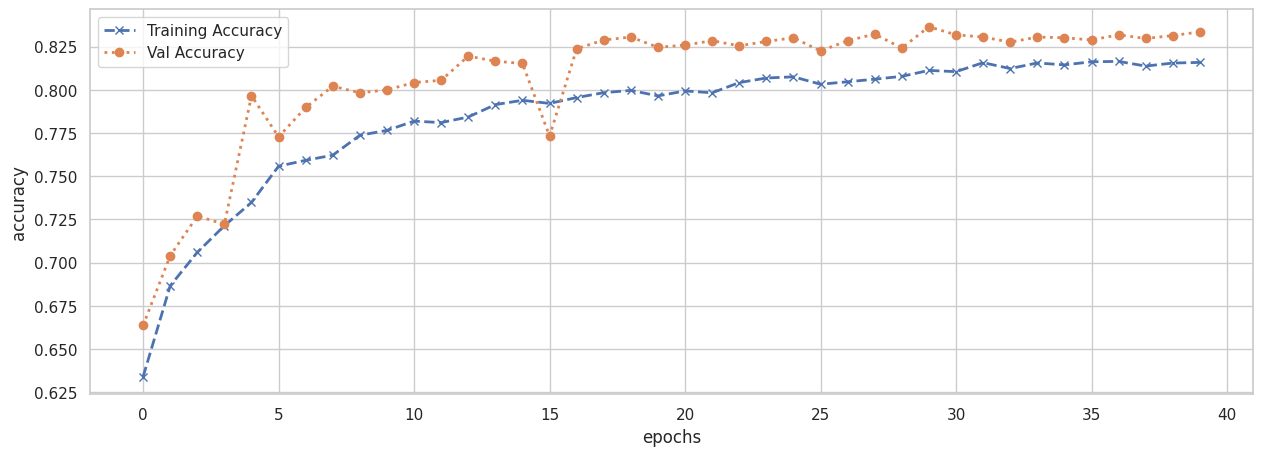

In [20]:
plt.plot(history.history["accuracy"], label="Training Accuracy", marker="x", ls="--", linewidth=2)
plt.plot(history.history["val_accuracy"], label="Val Accuracy", marker="o", ls=":", linewidth=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.savefig("./images/training.png")

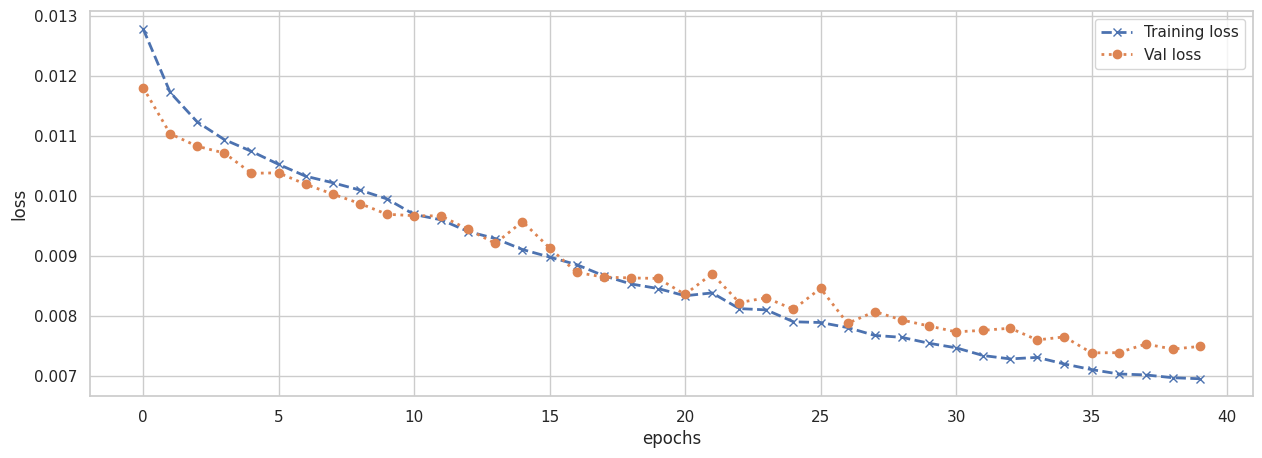

In [21]:
plt.plot(history.history["loss"], label="Training loss", marker="x", ls="--", linewidth=2)
plt.plot(history.history["val_loss"], label="Val loss", marker="o", ls=":", linewidth=2)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.savefig("./images/loss.png")

In [22]:
model.load_weights("./models/ckpt")
test_preds = model.predict(X_test)
test_preds

2022-12-30 16:52:49.357668: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./models/ckpt: FAILED_PRECONDITION: models/ckpt; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


74/74 [==============================] - 2s 10ms/step


array([[0.        , 0.        , 0.1202369 , 0.06368355],
       [0.        , 0.14188306, 0.        , 0.        ],
       [0.03713711, 0.        , 0.34680706, 0.07694506],
       ...,
       [0.        , 0.08313832, 0.        , 0.09411278],
       [0.        , 0.        , 0.11091619, 0.        ],
       [0.        , 0.        , 0.05278536, 0.07506582]], dtype=float32)

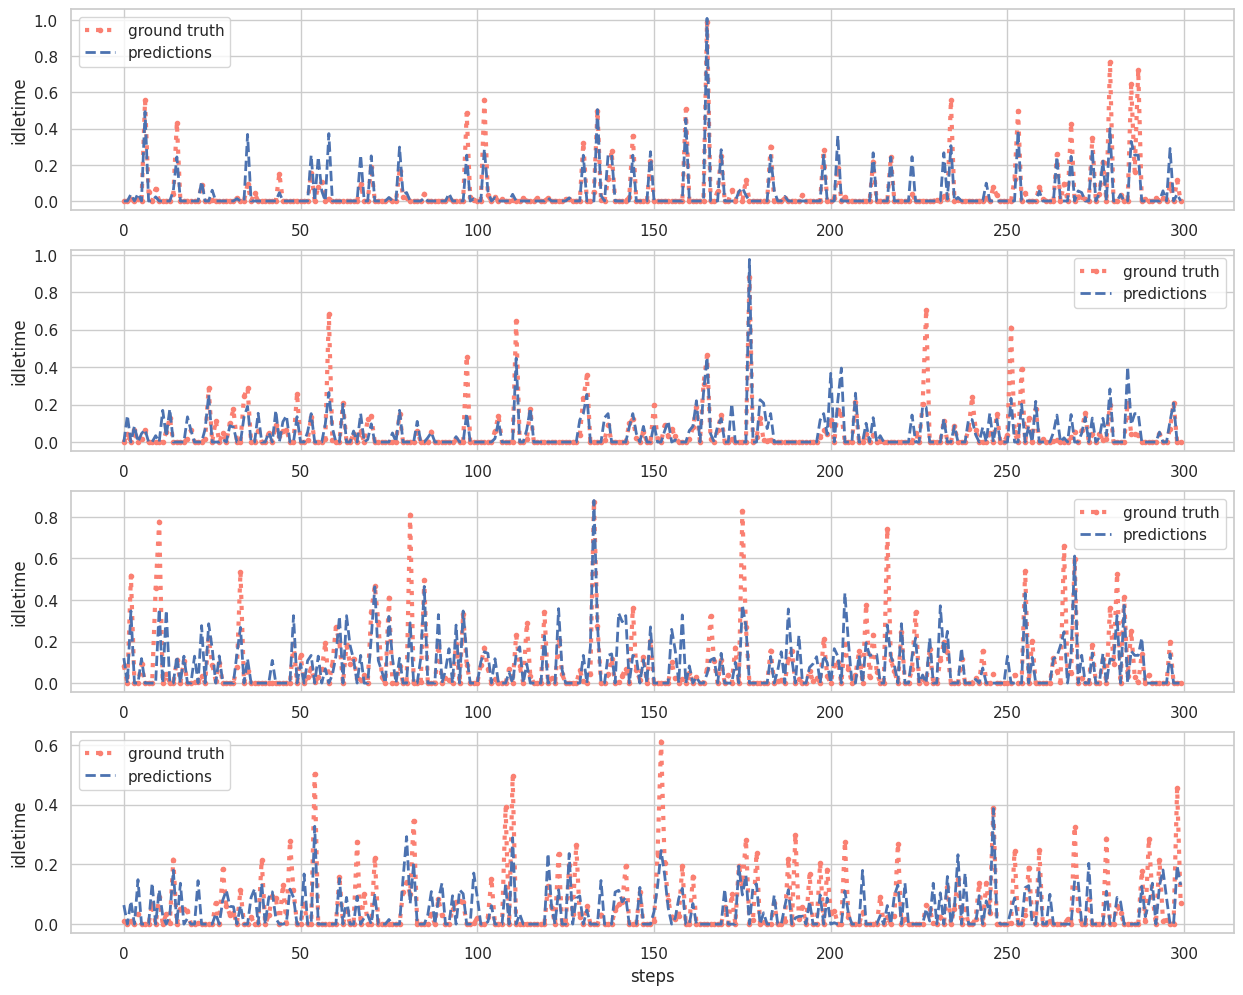

In [23]:
nchannels = y.shape[1]
fig, ax = plt.subplots(nrows=nchannels, ncols=1, figsize=(15, 12))
for i in range(nchannels):
  ax[i].plot(y_test[:300, i], label="ground truth", marker=".", ls=":", linewidth=3, color="salmon")
  ax[i].plot(test_preds[:300, i], label="predictions", ls="--", linewidth=2)
  ax[i].legend()
  ax[i].set_ylabel("idletime")
  if i == nchannels-1:
    ax[i].set_xlabel("steps")
plt.savefig("./images/predictions.png")

### Save the model 💾

In [24]:
def save_model(model, filename="model.tflite"):
  # convert the keras model to tflite
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
  ]

  tflite_model = converter.convert()

  # save the tflite model
  with open(filename, "wb") as f:
    f.write(tflite_model)

In [25]:
save_model(model, "./models/model.tflite")

INFO:tensorflow:Assets written to: /tmp/tmp24ot_q0e/assets


INFO:tensorflow:Assets written to: /tmp/tmp24ot_q0e/assets
2022-12-30 16:54:17.066973: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-30 16:54:17.067022: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-12-30 16:54:17.067837: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp24ot_q0e
2022-12-30 16:54:17.104006: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-12-30 16:54:17.104051: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp24ot_q0e
2022-12-30 16:54:17.206128: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2022-12-30 16:54:17.234326: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-12-30 16:54:17.448078: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio